<a href="https://colab.research.google.com/github/imji0319/PDSH/blob/master/NewYorkTaxi_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [10]:
cd /content/gdrive/My Drive/data

/content/gdrive/My Drive/data


In [2]:
ls

 credit_card.xls   mercari_train.tsv  'Online Retail.xlsx'   train.csv


In [0]:
import numpy as np
import pandas as pd

In [4]:
train_df = pd.read_csv('train.csv', nrows=10_000_000)

print(train_df.shape)
print(train_df.info())
train_df.head(3)

(10000000, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 8 columns):
key                  object
fare_amount          float64
pickup_datetime      object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: float64(5), int64(1), object(2)
memory usage: 610.4+ MB
None


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2


50M의 데이터를 한번에 불러오기 어려움 - 메모리 부족 
-> 10,000,000로 나눠서 진행

위도, 경도의 절대값 차이를 diff distance로 이동거리로 하여 input 값으로 사용

In [0]:
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude-df.pickup_latitude).abs()

In [6]:
add_travel_vector_features(train_df)
train_df.head(3)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,0.002701,0.009041
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,0.036780,0.070701
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,0.008504,0.010708


In [7]:
print(train_df.isnull().sum())

key                    0
fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude     69
dropoff_latitude      69
passenger_count        0
abs_diff_longitude    69
abs_diff_latitude     69
dtype: int64


In [8]:
print('Old size : %d'  %len(train_df))

train_df = train_df.dropna(how='any', axis='rows')

print('New size : %d'  %len(train_df))

Old size : 10000000
New size : 9999931


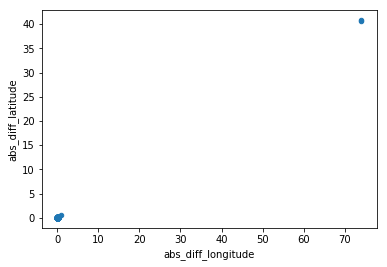

In [11]:
plot = train_df.iloc[:2000].plot.scatter('abs_diff_longitude', 'abs_diff_latitude')

#### 뉴욕 이라는 한 도시 내에서 발생하는 차이 만을 고려하기 때문에 그 차이가 0-1 사이의 값을 가지는 것을 기대함. 
#### 중간 값이 없는 상태에서 차이가 5이상으로 보이는 값들이 존재. 이를 제거할 필요가 있음.

In [12]:
print('Old Size : %d'  %len(train_df))

train_df = train_df[(train_df.abs_diff_longitude < 5.0) & (train_df.abs_diff_latitude < 5.0)]

print('New Size : %d'  %len(train_df))

Old Size : 9999931
New Size : 9979187


## Train model : Linear Model

In [0]:
def get_input_matrix(df):
    return np.column_stack((df.abs_diff_longitude, df.abs_diff_latitude, np.ones(len(df))))

In [15]:
train_X = get_input_matrix(train_df)
train_y = np.array(train_df['fare_amount'])

print(train_X.shape)
print(train_y.shape)

(9979187, 3)
(9979187,)


In [16]:
(w, _, _, _) = np.linalg.lstsq(train_X, train_y, rcond = None)
print(w)

[147.16176525  76.95503724   6.39545245]


In [17]:
test_df = pd.read_csv('test.csv')

print(test_df.info())
test_df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
key                  9914 non-null object
pickup_datetime      9914 non-null object
pickup_longitude     9914 non-null float64
pickup_latitude      9914 non-null float64
dropoff_longitude    9914 non-null float64
dropoff_latitude     9914 non-null float64
passenger_count      9914 non-null int64
dtypes: float64(4), int64(1), object(2)
memory usage: 542.2+ KB
None


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1


In [0]:
add_travel_vector_features(test_df)
test_X = get_input_matrix(test_df)


test_y_prediction = np.matmul(test_X, w).round(decimals = 2)

In [0]:
submission = pd.DataFrame({'key' : test_df.key,
                          'fare_amount': test_y_prediction},
                         columns =['key','fare_amount'])

submission.to_csv('submission1.csv', index=False)